In [1]:
import umap

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, pathlib, time
from tqdm import tqdm
# from sklearn import datasets

In [3]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [4]:
from tqdm import tqdm
import os, time, sys
import json

In [5]:
import dtnnlib as dtnn

In [6]:
mnist_transform = T.Compose([
    T.ToTensor(),
#     T.Normalize(
#         mean=[0.5,],
#         std=[0.5,],
#     ),
])

train_dataset = datasets.FashionMNIST(root="../../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.FashionMNIST(root="../../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [7]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [8]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


In [9]:
xx.min(), xx.max()

(tensor(0.), tensor(1.))

In [10]:
train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [45]:
embed = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [320]:
selected_points = test_dataset.data.reshape(-1, 28*28).type(torch.float32)/255
embedding = embed.fit_transform(selected_points)
# embedding = embed.fit_transform(centers, output_cent)

In [321]:
for xx, yy in train_loader:
    xx = xx.reshape(-1, 28*28)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 784]) torch.Size([50])


In [322]:
xx.max()

tensor(1.)

In [323]:
xtransf = embed.transform(xx.numpy().reshape(-1, 28*28))

In [324]:
xx.max()

tensor(1.)

In [325]:
transform = dtnn.DistanceTransformBase(28*28, len(test_dataset))
transform.centers.data = selected_points

In [326]:
test_dataset.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [327]:
# transform = nn.Linear(784, 785)


In [328]:
i = -1

In [357]:
i += 1
with torch.no_grad():
    dists = transform(xx[i:i+1])
dists.shape
print(yy[i])

tensor(1)


index:1/1


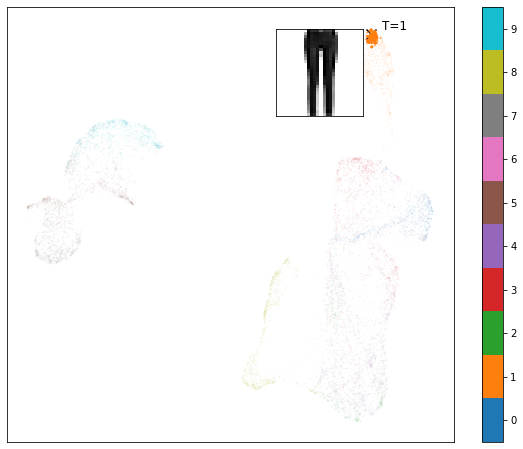

In [358]:
activ = dists.data.cpu().numpy()[0]

# activ = -activ ## use for linear only
activ = activ - activ.min()
activ = np.exp(-activ*7) #*0.05 for linear *3 for dist

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.6,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.show()


In [359]:
activ.max()

1.0

In [386]:
def get_sigma(dists, k=50, epoch=700):
    dists = torch.topk(dists, k=k,dim=1)[0]
    sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
    optim = torch.optim.Adam([sigma], lr=0.03)
    target = torch.log2(torch.ones_like(sigma)*k).to(dists.device)
    print(sigma, target)
    for i in range(epoch):
        delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
        print(delta.data, sigma.data)
        delta = delta-target

        optim.zero_grad()
        error = (delta**2).sum()
        error.backward()
        optim.step()
    print(sigma, delta)
    return sigma.data

In [387]:
sigma = get_sigma(dists)

Parameter containing:
tensor([[0.0640]], requires_grad=True) tensor([[5.6439]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
te

tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]]) tensor([[0.0640]])
tensor([[0.]])

## Get scale to top-k points

In [388]:
i = -1

In [389]:
i += 1
with torch.no_grad():
    dists = transform(xx[i:i+1])
dists.shape
print(yy[i])

tensor(2)


In [390]:
dists = dists-dists.min(dim=1, keepdim=True)[0]
# dists = torch.topk(dists, k=50,dim=1)[0]
sigma = get_sigma(dists, k=10000)
topk_dists = torch.exp(-dists/sigma)

Parameter containing:
tensor([[0.3926]], requires_grad=True) tensor([[13.2877]])
tensor([[7.8402]]) tensor([[0.3926]])
tensor([[10.0620]]) tensor([[0.4226]])
tensor([[12.6439]]) tensor([[0.4519]])
tensor([[15.1894]]) tensor([[0.4769]])
tensor([[16.4670]]) tensor([[0.4884]])
tensor([[16.2637]]) tensor([[0.4866]])
tensor([[15.2803]]) tensor([[0.4778]])
tensor([[14.0281]]) tensor([[0.4659]])
tensor([[12.8420]]) tensor([[0.4539]])
tensor([[11.9287]]) tensor([[0.4442]])
tensor([[11.3754]]) tensor([[0.4381]])
tensor([[11.1829]]) tensor([[0.4359]])
tensor([[11.3102]]) tensor([[0.4373]])
tensor([[11.7023]]) tensor([[0.4417]])
tensor([[12.2939]]) tensor([[0.4482]])
tensor([[13.0023]]) tensor([[0.4556]])
tensor([[13.7178]]) tensor([[0.4628]])
tensor([[14.3083]]) tensor([[0.4686]])
tensor([[14.6536]]) tensor([[0.4719]])
tensor([[14.6942]]) tensor([[0.4723]])
tensor([[14.4530]]) tensor([[0.4700]])
tensor([[14.0155]]) tensor([[0.4658]])
tensor([[13.4933]]) tensor([[0.4606]])
tensor([[12.9938]]) ten

tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tenso

tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tensor([[0.4585]])
tensor([[13.2877]]) tenso

In [391]:
topk_dists.shape

torch.Size([1, 10000])

In [392]:
topk_dists.max(), topk_dists.min()

(tensor(1.), tensor(2.1054e-13))

index:0/1


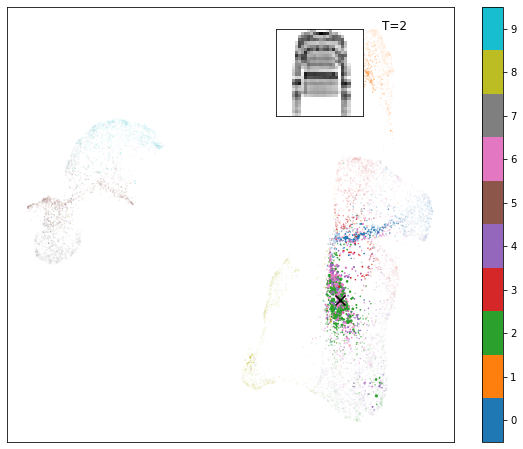

In [393]:
activ = topk_dists.data.cpu().numpy()[0]

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.6,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

plt.show()


### Visualize for Distance based Umap - but Dot product activation

In [309]:
transform2 = nn.Linear(28*28, len(test_dataset))
transform2.weight.data = selected_points

In [310]:
i = -1

In [311]:
i += 1
with torch.no_grad():
    dists = -transform2(xx[i:i+1])
dists.shape
print(yy[i])

tensor(7)


In [312]:
dists = dists-dists.min(dim=1, keepdim=True)[0]
sigma = get_sigma(dists)
topk_dists = torch.exp(-dists/sigma)

Parameter containing:
tensor([[4.6928]], requires_grad=True) tensor([[5.6439]])
Parameter containing:
tensor([[2.9179]], requires_grad=True) tensor([[6.6757e-06]], grad_fn=<SubBackward0>)


In [313]:
topk_dists.max(), topk_dists.min()

(tensor(1.), tensor(7.9916e-19))

index:0/1


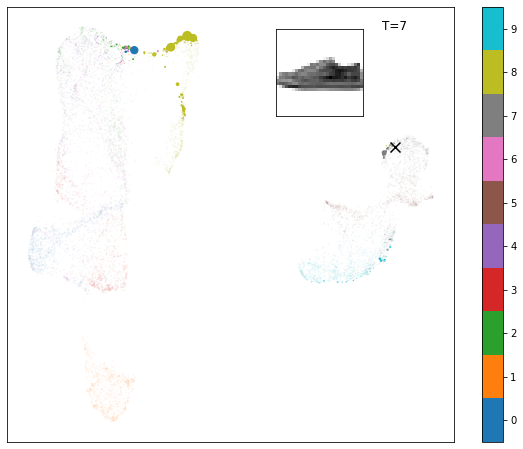

In [314]:
activ = topk_dists.data.cpu().numpy()[0]

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.6,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

plt.show()


In [319]:
torch.topk(dists, k=50,dim=1)[0]

tensor([[121.5914, 121.5279, 120.7313, 120.4644, 118.9041, 118.5559, 118.5390,
         118.1996, 117.1297, 116.6832, 116.5937, 116.5698, 116.4213, 116.2928,
         116.0142, 115.4682, 115.2146, 115.0874, 114.7755, 114.6628, 114.6312,
         114.6161, 114.5155, 114.4777, 114.3908, 114.3302, 114.0812, 114.0180,
         113.8707, 113.8489, 113.7967, 113.6854, 113.6328, 113.5947, 113.5911,
         113.5317, 113.4529, 113.4382, 113.4239, 113.3752, 113.3659, 113.3299,
         113.3097, 113.2678, 113.2209, 112.9902, 112.8899, 112.7895, 112.7494,
         112.7471]])